In [1]:
%matplotlib inline

# Example: Hay et al. (2011) spike waveform on in vitro MEA slice set-up.
It serves to demonstrate class LFPy.RecMEAElectrode which incorporates discontinous extracellular
conductivity (MEA chip, slice, saline) in comparison to LFPy.RecExtElectrode
which incorporates an infinite homogeneous isotropic/anisotropic extracellular
conductivity. 

Runs Hay et al. (2011) layer 5b pyramidal cell model, generating and plotting
action potentials and corresponding extracellular potentials (spikes)

Note that the entire cell must fit within the slice for the calculation of the MEA potentials to work, meaning that some z-positions of the cell will result in errors.

In [2]:
import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron

## Fetch Hay et al. 2011 model files

In [3]:
if not os.path.isfile('L5bPCmodelsEH/morphologies/cell1.asc'):
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=139653&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('L5bPCmodelsEH.zip', 'r')
    myzip.extractall('.')
    myzip.close()

#compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('L5bPCmodelsEH/mod/')

## Simulation parameters:

In [4]:
# define cell parameters used as input to cell-class
cell_parameters = {
    'morphology'    : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-5,
    'tstart' : -159,
    'tstop' : 100,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
}



# Create a grid of measurement locations, in (mum)
X = np.arange(0, 1001, 500)
Y = np.zeros(X.shape)
Z = np.zeros(X.shape) + 0

# Define electrode parameters
grid_electrode_parameters = {
    'sigma': 0.3,      # extracellular conductivity
    'x': X.flatten(),  # electrode requires 1d vector of positions
    'y': Y.flatten(),
    'z': Z.flatten(),
    "method": "soma_as_point",
    'N': np.array([[0, 0, 1]]*X.size), #surface normals
    'r': 50,              # contact site radius
    'n': 100,               # datapoints for averaging
    "seedvalue": 12,
}

# Define electrode parameters
MEA_electrode_parameters = {
    'sigma_T': 0.3,      # extracellular conductivity
    'sigma_G' : 0.0,      # MEA glass electrode plate conductivity
    'sigma_S' : 1.5,      # Saline bath conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    "method": "soma_as_point",
    'N' : np.array([[0, 0, 1]]*X.size), #surface normals
    'r' : 50,              # contact site radius
    'n' : 100,               # datapoints for averaging,
    'h': 300,
    "seedvalue": 12,
    "squeeze_cell_factor": 0.6,  # Determines how much to squeeze the cell to make it fit within the slice
}

## Plotting functions

In [5]:
def plot_results(cell, synapse, MEA, electrode):

    time_window = [0, 50]
    syn_idx = synapse.idx

    cell_plot_idxs = [cell.somaidx[0], syn_idx]
    cell_plot_colors = {cell.somaidx[0]: 'y',
                        syn_idx: 'orange',}
    num_cols = 4

    fig = plt.figure(figsize=[15, 5])
    plt.subplots_adjust(hspace=0.6, wspace=0.3, right=0.99, left=0.03, top=0.9)
    ax1 = fig.add_axes([0.05, 0.5, 0.37, 0.4], aspect=1, frameon=False,
                       xticks=[], yticks=[], title='Top view')
    ax3 = fig.add_axes([0.05, 0.1, 0.37, 0.4], aspect=1, frameon=False,
                       xticks=[], yticks=[], title='Side view')

    ax_ec = fig.add_subplot(1, num_cols, 3, xlim=time_window,
                            xlabel='ms', ylabel='$\mu$V',
                            title='Extracellular\npotential')
    ax_v = plt.subplot(1, num_cols, 4, title='Membrane potential',
                       xlabel='ms', ylabel='mV',
                       ylim=[-80, 40], xlim=time_window)

    elec_clr = lambda idx: plt.cm.nipy_spectral(1./(len(MEA.x) - 1) * idx)

    l_elec, l_syn = plot_recording_set_up(cell, ax1, ax3, MEA, elec_clr,
                                              syn_idx, cell_plot_colors)
    [ax_v.plot(cell.tvec, cell.vmem[idx, :], c=cell_plot_colors[idx], lw=2)
        for idx in cell_plot_idxs]
    for elec in range(len(MEA.x)):
        ax_ec.plot(cell.tvec, 1000 * (MEA.LFP[elec]),
                   lw=2, c=elec_clr(elec))
        ax_ec.plot(cell.tvec, 1000 * (electrode.LFP[elec]),
                   lw=3, c=elec_clr(elec), ls=":")

    l_MEA, = ax_ec.plot(0, 0, lw=2, c="k")
    l_invivo, = ax_ec.plot(0, 0, lw=2, c="k", ls=":")

    fig.legend([l_syn, l_elec, l_MEA, l_invivo], ["Synapse", "Electrode", "Slice", "In vivo"],
               frameon=False, numpoints=1, ncol=4, loc=3)
    simplify_axes([ax_v, ax_ec])
    mark_subplots([ax1, ax3, ax_ec, ax_v], ypos=1.05, xpos=-0.1)

    

def plot_recording_set_up(cell, ax_neur, ax_side, MEA, elec_clr,
                           syn_idx, cell_plot_colors):
    """ Function to make nice plot of the MEA set-up """
    for comp in range(len(cell.xmid)):
        if comp == 0:
            ax_neur.scatter(cell.xmid[comp], cell.ymid[comp], s=cell.diam[comp],
                            edgecolor='none', color='gray', zorder=1)
        else:
            ax_neur.plot([cell.xstart[comp], cell.xend[comp]],
                         [cell.ystart[comp], cell.yend[comp]],
                         lw=cell.diam[comp]/2, color='gray', zorder=1)

    for comp in range(len(cell.xmid)):
        if comp == 0:
            ax_side.scatter(cell.xmid[comp], cell.zmid[comp], s=cell.diam[comp],
                            edgecolor='none', color='gray', zorder=1)
        else:
            ax_side.plot([cell.xstart[comp], cell.xend[comp]],
                         [cell.zstart[comp], cell.zend[comp]],
                         lw=cell.diam[comp]/2, color='gray', zorder=1)
    for idx in range(len(MEA.x)):
        ax_side.plot(MEA.x[idx], MEA.z[idx] - 10, 's', clip_on=False,
                     c=elec_clr(idx), zorder=10, mec='none')
        ax_side.plot([MEA.x[idx], MEA.x[idx]], [MEA.z[idx] - 10, MEA.z[idx] - 150],
                     c=elec_clr(idx), zorder=10, lw=2)
        ax_neur.plot(MEA.x[idx], MEA.y[idx], 's', c=elec_clr(idx), zorder=10)

    ax_side.axhspan(-250, 0, facecolor='0.5', edgecolor='none')
    ax_side.axhspan(0, MEA.h, facecolor='lightsalmon', edgecolor='none')
    ax_side.axhspan(MEA.h, MEA.h + 250, facecolor='aqua', edgecolor='none')
    ax_neur.axhspan(-500, 500, facecolor='lightsalmon', edgecolor='none')

    l_elec, = ax_neur.plot(MEA.x[0], MEA.y[0], 's', c=elec_clr(0), zorder=0)

    l_syn, = ax_neur.plot(cell.xmid[syn_idx], cell.ymid[syn_idx], '*',
                           c=cell_plot_colors[syn_idx], ms=15)

    ax_side.plot(cell.xmid[syn_idx], cell.zmid[syn_idx], '*',
                 c=cell_plot_colors[syn_idx], ms=15)

    ax_neur.arrow(-220, -100, 30, 0, lw=1, head_width=12, color='k', clip_on=False)
    ax_neur.arrow(-220, -100, 0, 30, lw=1, head_width=12, color='k', clip_on=False)
    ax_neur.text(-150, -100, 'x', size=10, ha='center', va='center', clip_on=False)
    ax_neur.text(-220, -20, 'y', size=10, ha='center', va='center', clip_on=False)

    ax_side.arrow(-220, 20, 30, 0, lw=1, head_width=12, color='k', clip_on=False)
    ax_side.text(-140, 25, 'x', size=10, ha='center', va='center')
    ax_side.arrow(-220, 20, 0, 30, lw=1, head_width=12, color='k', clip_on=False)
    ax_side.text(-220, 100, 'z', size=10, ha='center', va='center')

    ax_side.plot([-500, 1250], [MEA.h, MEA.h], color='k')
    ax_side.plot([-500, 1250], [0, 0], 'k')  # PLOTTING BOTTOM OF MEA

    ax_side.plot([1280, 1280], [0, MEA.h], '_-',
                 color='k', lw=2, clip_on=False, solid_capstyle='butt')
    ax_side.text(1300, MEA.h / 2, '%g $\mu$m' % MEA.h, size=8, va='center')

    ax_side.text(1200, -10, 'MEA', va='top', ha='right')
    ax_side.text(1200, MEA.h, 'Saline', va='bottom', ha='right')
    ax_side.text(1200, MEA.h - 50, 'Tissue', va='top', ha='right')

    ax_side.axis([-300, 1250, -70, MEA.h + 70])
    ax_neur.axis([-300, 1250, -250, 250])

    return l_elec, l_syn


def simplify_axes(axes):
    """
    Right and top axis line is removed from axes or list of axes

    """
    if not type(axes) is list:
        axes = [axes]

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()


def mark_subplots(axes, letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ', xpos=-0.12, ypos=1.15):
    """ Marks subplots in axes (should be list or axes object) with capital letters
    """
    if not type(axes) is list:
        axes = [axes]

    for idx, ax in enumerate(axes):
        ax.text(xpos, ypos, letters[idx].capitalize(),
                horizontalalignment='center',
                verticalalignment='center',
                fontweight='demibold',
                fontsize=12,
                transform=ax.transAxes)

## Main simulation procedure, setting up extracellular electrode, cell, synapse:

In [6]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# Create cell
cell = LFPy.TemplateCell(**cell_parameters)
# Align cell
cell.set_rotation(z=-np.pi/2)

# Here, the height of the cell within the tissue slice is set 
cell.set_pos(z=50)

synapse_parameters = {
    'idx': 0,
    'e': 0.,                   # reversal potential
    'syntype': 'ExpSyn',       # synapse type
    'tau': 1.,                 # synaptic time constant
    'weight': .1,            # synaptic weight
    'record_current': True,    # record synapse current
}

# Create synapse and set time of synaptic input
synapse = LFPy.Synapse(cell, **synapse_parameters)
synapse.set_spike_times(np.array([10.]))

# perform NEURON simulation, results saved as attributes in the cell instance
cell.simulate(rec_imem=True, rec_vmem=True)

# create extracellular electrode object for extracellular potential
electrode = LFPy.RecExtElectrode(cell, **grid_electrode_parameters)
MEA = LFPy.RecMEAElectrode(cell, **MEA_electrode_parameters)
MEA.calc_lfp()
electrode.calc_lfp()

# remove any potential DC-component of the extracellular signals
MEA.LFP -= MEA.LFP[:, 0, None]
electrode.LFP -= electrode.LFP[:, 0, None]


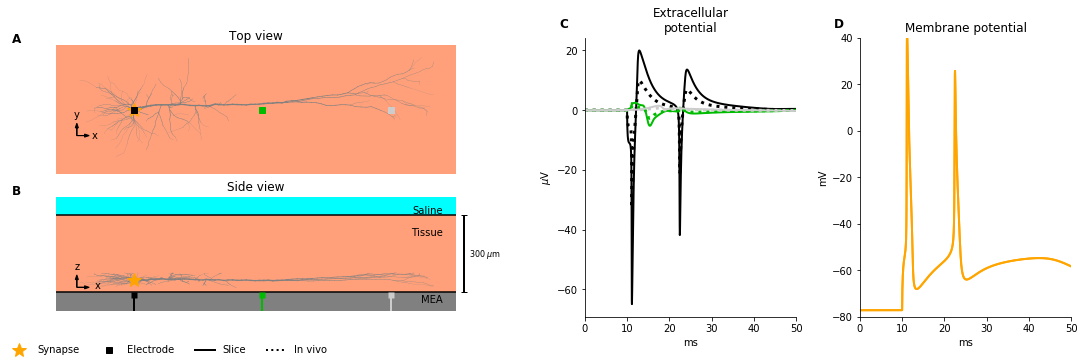

In [7]:
plot_results(cell, synapse, MEA, electrode)
# Optional: save image
# plt.savefig('example_MEA_spike.pdf', dpi=150)